In [1]:
import sys
sys.path.append('../../')
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from utils.dataset import Segmentation_CustomDataset as CustomDataset
from model.load_model import segmentation_models_loader 
import os
import torch.optim as optim
import numpy as np
from utils.__init__ import *
from utils import * 
os.environ['KMP_DUPLICATE_LIB_OK']='True'


2024-05-29 22:06:55.527369: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 22:06:55.555295: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


torch.Size([8, 1, 512, 512]) torch.Size([8, 1, 512, 512])
tensor([0., 1.])


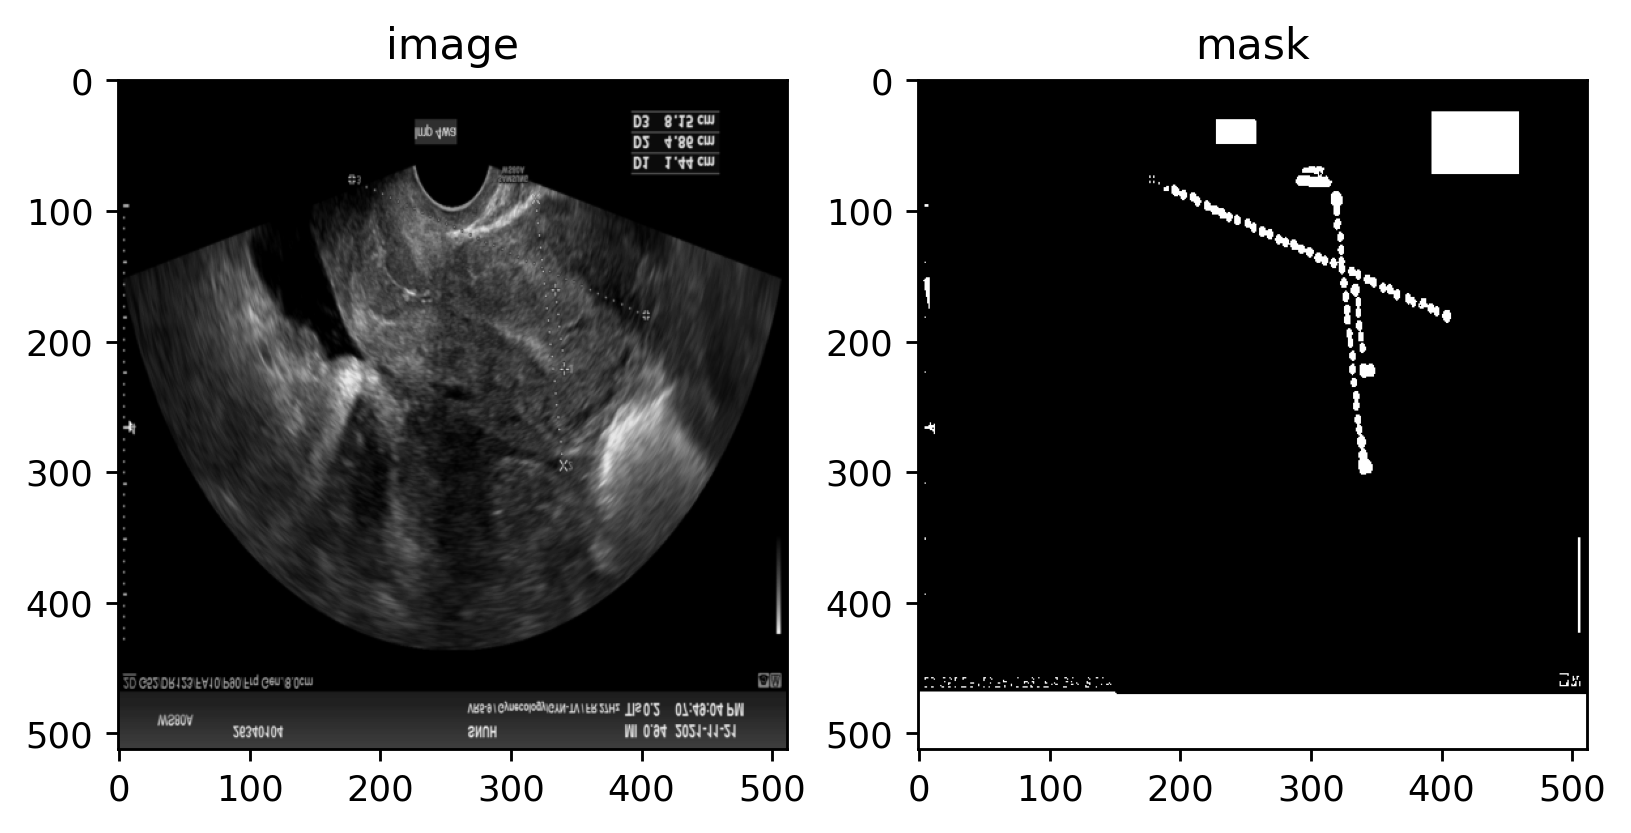

In [2]:
tr_img_dir = '/mnt/HDD/octc/seg_data/train_img'
tr_mask_dir = '/mnt/HDD/octc/seg_data/train_mask' 
vl_img_dir = '/mnt/HDD/octc/seg_data/valid_img' 
vl_mask_dir = '/mnt/HDD/octc/seg_data/valid_img' 

transforms_dict = {
    'train': transforms.Compose([
        # transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize((512, 512)),
        # transforms.RandomResizedCrop(512, scale=(0.75, 1.0), ratio=(0.75, 1.33)),
        # transforms.RandomCrop(size = (512,512), pad_if_needed=True, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 밝기와 대비 조정
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
}

# Dataset and DataLoader setup
train_dataset = CustomDataset(
    image_dir = tr_img_dir,
    mask_dir = tr_mask_dir,
    transform=transforms_dict['train'],
    testing=False,
)

valid_dataset = CustomDataset(
    image_dir = vl_img_dir,
    mask_dir = vl_mask_dir,
    transform=transforms_dict['valid'],
    testing=True,  # Disables random transformations for validation
    seed = 627
)
tr_batch, vl_batch = 8, 8
train_loader = DataLoader(dataset = train_dataset, batch_size = tr_batch, shuffle = True)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle = False)

for images, masks in train_loader:
    print(images.shape, masks.shape)
    print(masks.unique())
    train_plotting(images, masks)
    break

# for images, masks, paths in valid_loader:
#     print(images.shape, masks.shape)
#     train_plotting(images, masks)
#     break


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seg_model_loader = segmentation_models_loader(
    model_name = 'unet_plus_plus',
    width = 512,
    height = 512
)
model = seg_model_loader().to(device)
for p in model.parameters():
    if p.dim() > 1:
            nn.init.kaiming_uniform_(p)
            
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss().to(device)
metrics = {
    't_bce_loss':[],
    'v_bce_loss':[],
}

Model: Unet++ loaded successfully!! | pretrained : imagenet


In [4]:
save_path = '/mnt/HDD/chest-seg_models/swin-unet'
os.makedirs(save_path, exist_ok=True)
for epoch in range(500):
    t_losses, v_losses = 0., 0.
    model.train()
    for images, masks in train_loader:
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        outputs = model.forward(images.to(device)).to(device)
        
        # BCE Logistic Loss
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        
        t_losses += loss.cpu().detach().item()

    with torch.no_grad():
        model.eval()
        for images, masks, paths in valid_loader:
            images, masks = images.to(device), masks.to(device)
            ### inference
            outputs = model.forward(images.to(device)).to(device)  # 3+1ch
            
            loss = loss_fn(outputs, masks)
            v_losses += loss.cpu().detach().item()
    # if epoch % 5 == 0:
    #     save_validation(images, masks, outputs, epoch, save_dir = save_path)
    #     save_model(model, optimizer, epoch, save_dir = save_path)
    #     save_loss(metrics, save_dir = save_path)

    metrics['t_bce_loss'].append(t_losses / len(train_loader))
    metrics['v_bce_loss'].append(v_losses / len(valid_loader))

    print("#" * 100)    
    print(f"Train - BCE LOSS : {metrics['t_bce_loss'][-1]}")
    print(f"Valid - BCE LOSS : {metrics['v_bce_loss'][-1]} \n")
    print("#" * 100)
    


####################################################################################################
Train - BCE LOSS : 0.4212644249200821
Valid - BCE LOSS : 0.5854083796342214 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.2172754527284549
Valid - BCE LOSS : 0.5698370933532715 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.1571427767093365
Valid - BCE LOSS : 0.5489707191785177 

####################################################################################################
####################################################################################################
Train - BCE LOSS : 0.12503350941607586
Valid - BCE LOSS : 0

KeyboardInterrupt: 

In [ ]:
# model weight에서 dead weight 파라미터 개수 확인 
# 출력 : dead_weight / total_weight 
dead_weight, total_weight = 0, 0
for p in model.parameters():
    total_weight += p.numel()
    dead_weight += (p == 0).sum().item()
print(f"Dead Weight : {dead_weight} / {total_weight} = {dead_weight / total_weight * 100:.2f} %")



Dead Weight : 14400 / 6827625 = 0.21 %
